Fetching data for SPY...
Engineering Features (FracDiff, Yang-Zhang)...
Detecting Market Regimes (Unsupervised Learning)...
Signals Generated.
--- Performance: SPY ---
Total Return: nan%
Sharpe Ratio: 0.80

Plotting results... (Close window to finish)


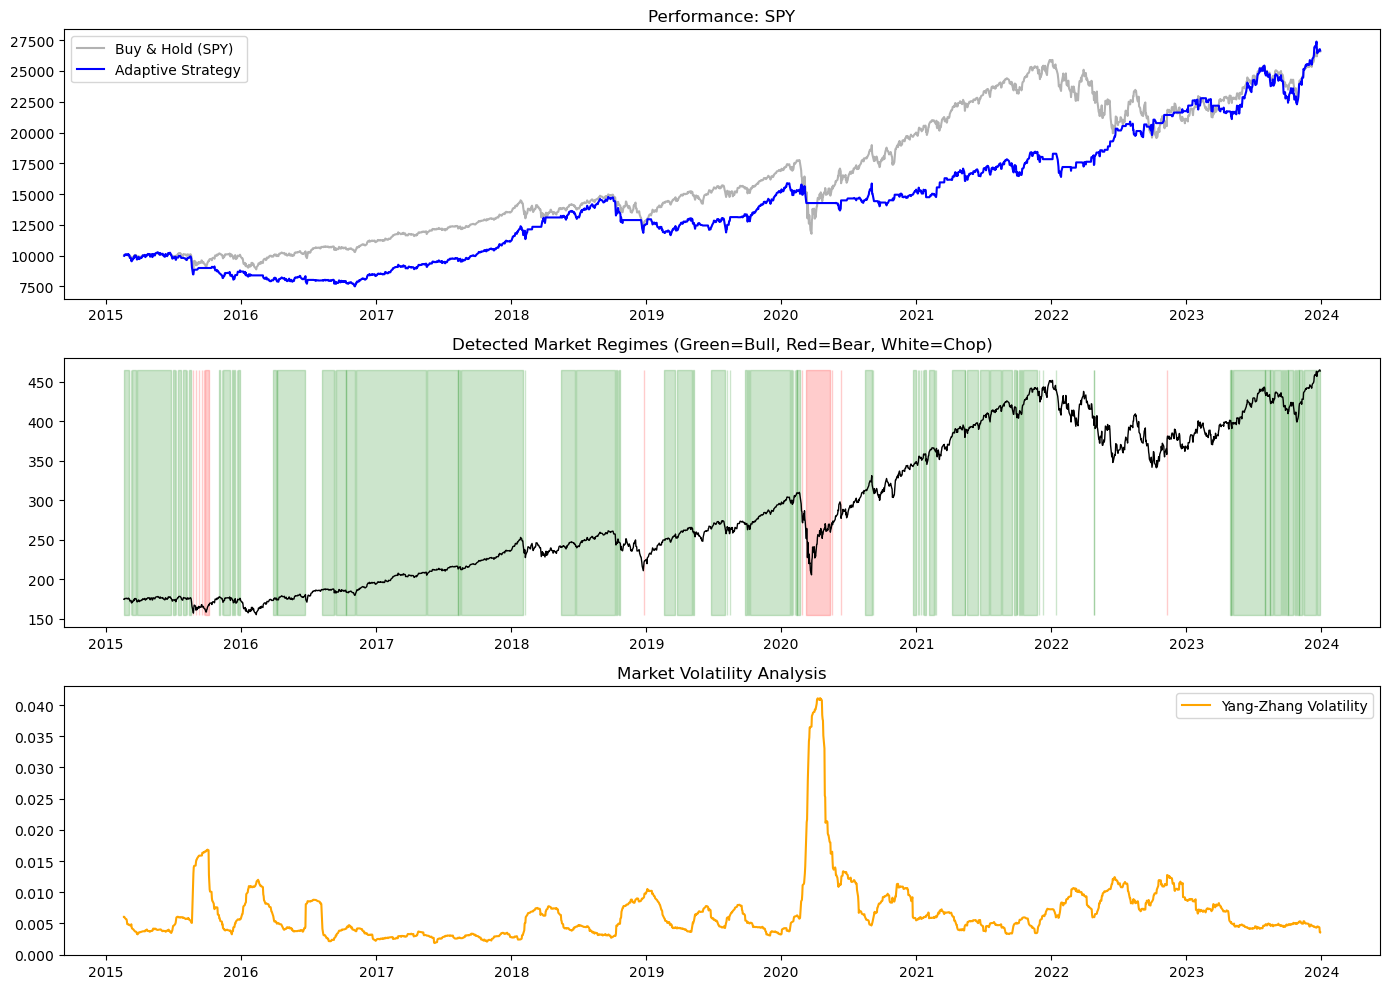

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
import warnings

# Suppress warnings for cleaner output in a research environment
warnings.filterwarnings('ignore')

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (Math Lab)
# ==========================================

class FeatureLab:
    """
    Implements advanced signal processing techniques described in the MIT research plan.
    Includes Fractional Differentiation and Yang-Zhang Volatility.
    """

    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        """
        Calculates weights for fractional differentiation using the binomial expansion.
        Ref: Section 2.1.1 of Research Plan.
        """
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        
        w = np.array(w[::-1])
        # optimize weights by cutting off small values
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=20):
        """
        Applies fractional differentiation to a pandas Series.
        Preserves memory while achieving stationarity.
        """
        # Note: In a full production system, we would solve for optimal 'd' using ADF test.
        # Here we use a fixed 'd' (e.g., 0.4) and window for demonstration speed.
        weights = FeatureLab.get_weights_frac_diff(d, window)
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        """
        Computes Yang-Zhang Volatility: Minimum variance, unbiased, drift-independent.
        Ref: Section 2.2 of Research Plan.
        
        Formula: sigma_YZ^2 = sigma_ON^2 + k * sigma_RS^2
        """
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        
        yz_vol = np.sqrt(open_vol + k * window_rs)
        return yz_vol

    @staticmethod
    def compute_relative_strength(series, window=14):
        """Standard RSI for Mean Reversion components."""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

# ==========================================
# 2. MARKET REGIME DETECTION (Behavioral Lab)
# ==========================================

class RegimeIdentifier:
    """
    Uses Unsupervised Learning (GMM) to decode latent market states.
    Ref: Section 3.1 & 3.2 of Research Plan.
    """
    def __init__(self, n_components=3):
        # 3 components: 0=Bear/HighVol, 1=Sideways, 2=Bull/LowVol (Labels may vary after training)
        self.model = GaussianMixture(n_components=n_components, covariance_type="full", random_state=42)
        self.scaler = StandardScaler()
        self.is_fitted = False

    def fit_predict(self, df):
        """
        Fits GMM on Returns and Volatility to identify regimes.
        Returns the dataframe with a 'Regime' column.
        """
        data = df.copy().dropna()
        
        # Features for Regime Detection:
        # 1. Weekly Returns (Trend)
        # 2. Yang-Zhang Volatility (Risk)
        X = data[['Returns', 'Volatility']].values
        
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Fit GMM
        self.model.fit(X_scaled)
        regimes = self.model.predict(X_scaled)
        
        data['Regime'] = regimes
        self.is_fitted = True
        
        # We need to map the GMM labels (0,1,2) to semantic meaning based on stats.
        # Calculate mean return of each cluster to identify which is "Bull"
        regime_stats = data.groupby('Regime')['Returns'].mean()
        
        # Heuristic mapping:
        # Highest Mean Return -> Bull (Mapped to 1)
        # Lowest Mean Return -> Bear (Mapped to -1)
        # Middle -> Sideways (Mapped to 0)
        
        sorted_regimes = regime_stats.sort_values().index # [Lowest, Middle, Highest]
        mapping = {
            sorted_regimes[0]: -1, # Bear
            sorted_regimes[1]: 0,  # Sideways
            sorted_regimes[2]: 1   # Bull
        }
        
        data['Regime_Label'] = data['Regime'].map(mapping)
        return data

# ==========================================
# 3. STRATEGY ABSTRACTION
# ==========================================

class Strategy(ABC):
    """Abstract Base Class for all trading strategies."""
    
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None

    def fetch_data(self):
        print(f"Fetching data for {self.ticker}...")
        # auto_adjust=False ensures we try to get 'Adj Close'
        try:
            self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date, progress=False, auto_adjust=False)
        except Exception as e:
            print(f"Warning: Download failed or returned empty: {e}")
            return

        # Fix for multi-index columns in recent yfinance
        if isinstance(self.data.columns, pd.MultiIndex):
            # If (Price, Ticker) format, get level 0
            self.data.columns = self.data.columns.get_level_values(0)

        # Robust Fallback: If 'Adj Close' is missing, use 'Close'
        if 'Adj Close' not in self.data.columns:
            if 'Close' in self.data.columns:
                print("Note: 'Adj Close' column not found. Using 'Close' as fallback.")
                self.data['Adj Close'] = self.data['Close']
            else:
                raise KeyError(f"Neither 'Adj Close' nor 'Close' found for {self.ticker}. Columns: {self.data.columns}")

        self.data['Returns'] = self.data['Adj Close'].pct_change()
        self.data.dropna(inplace=True)

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, initial_capital=10000):
        """Vectorized Backtest Engine."""
        if 'Signal' not in self.data.columns:
            raise ValueError("Signals not generated yet.")
        
        df = self.data.copy()
        df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']
        
        # Cumulative Returns
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod() * initial_capital
        df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod() * initial_capital
        
        self.results = df
        return df

    def performance_metrics(self):
        df = self.results
        total_return = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0]) - 1
        sharpe = (df['Strategy_Returns'].mean() / df['Strategy_Returns'].std()) * np.sqrt(252)
        
        print(f"--- Performance: {self.ticker} ---")
        print(f"Total Return: {total_return:.2%}")
        print(f"Sharpe Ratio: {sharpe:.2f}")
        return total_return, sharpe

# ==========================================
# 4. CONCRETE STRATEGY: ADAPTIVE REGIME
# ==========================================

class AdaptiveRegimeStrategy(Strategy):
    """
    Implements the core thesis: Different regimes require different logic.
    Ref: Section 1.1 & 3.3 of Research Plan.
    """

    def generate_signals(self):
        print("Engineering Features (FracDiff, Yang-Zhang)...")
        
        # 1. Calculate Advanced Features
        self.data['Volatility'] = FeatureLab.yang_zhang_volatility(self.data)
        self.data['FracDiff'] = FeatureLab.frac_diff_fixed(self.data['Adj Close'].apply(np.log), d=0.4)
        self.data['RSI'] = FeatureLab.compute_relative_strength(self.data['Adj Close'])
        
        # Clean up NaN from windows
        self.data.dropna(inplace=True)
        
        # 2. Detect Regimes
        print("Detecting Market Regimes (Unsupervised Learning)...")
        regime_engine = RegimeIdentifier()
        self.data = regime_engine.fit_predict(self.data)
        
        # 3. Apply Regime-Specific Logic
        # Initialize Signal Column
        self.data['Signal'] = 0
        
        # --- Logic Definitions ---
        
        # BULL REGIME (1): Trend Following
        # If FracDiff trend is positive, go Long.
        # This uses the memory-preserving property of FracDiff.
        bull_condition = (self.data['Regime_Label'] == 1) & (self.data['FracDiff'] > 0)
        self.data.loc[bull_condition, 'Signal'] = 1
        
        # SIDEWAYS REGIME (0): Mean Reversion
        # Buy if RSI < 30 (Oversold), Sell if RSI > 70 (Overbought), else Hold/Neutral
        # Simplified vector logic: 
        sideways_long = (self.data['Regime_Label'] == 0) & (self.data['RSI'] < 35)
        sideways_short = (self.data['Regime_Label'] == 0) & (self.data['RSI'] > 65)
        
        self.data.loc[sideways_long, 'Signal'] = 1
        self.data.loc[sideways_short, 'Signal'] = -1 # Or 0 if long-only
        
        # BEAR REGIME (-1): Capital Preservation
        # Go to Cash (Signal 0) or Hedge.
        # Here we choose Cash for safety.
        bear_condition = (self.data['Regime_Label'] == -1)
        self.data.loc[bear_condition, 'Signal'] = 0 
        
        # 4. Volatility Targeting (Position Sizing)
        # Ref: Section 7.2. Adjust size based on Volatility.
        # Target Vol = 15% annualized. 
        # Position Size = Target / Current Vol
        target_vol = 0.15 / np.sqrt(252)
        self.data['Vol_Scaler'] = target_vol / self.data['Volatility']
        self.data['Vol_Scaler'] = self.data['Vol_Scaler'].clip(upper=1.5) # Cap leverage at 1.5x
        
        # Apply scaling to signal
        self.data['Signal'] = self.data['Signal'] * self.data['Vol_Scaler']

        print("Signals Generated.")

    def plot_results(self):
        plt.figure(figsize=(14, 10))
        
        # Subplot 1: Cumulative Returns
        ax1 = plt.subplot(3, 1, 1)
        ax1.plot(self.results['Cumulative_Market'], label='Buy & Hold (SPY)', color='gray', alpha=0.6)
        ax1.plot(self.results['Cumulative_Strategy'], label='Adaptive Strategy', color='blue')
        ax1.set_title(f"Performance: {self.ticker}")
        ax1.legend()
        
        # Subplot 2: Regimes
        ax2 = plt.subplot(3, 1, 2, sharex=ax1)
        # Create a colored background for regimes
        prices = self.data['Adj Close']
        
        # Helper to fill regions
        y_min, y_max = prices.min(), prices.max()
        
        # Masking for regimes
        bull_mask = self.data['Regime_Label'] == 1
        bear_mask = self.data['Regime_Label'] == -1
        
        ax2.plot(prices, color='black', linewidth=1)
        ax2.fill_between(self.data.index, y_min, y_max, where=bull_mask, color='green', alpha=0.2, label='Bull Regime')
        ax2.fill_between(self.data.index, y_min, y_max, where=bear_mask, color='red', alpha=0.2, label='Bear Regime')
        ax2.set_title("Detected Market Regimes (Green=Bull, Red=Bear, White=Chop)")
        
        # Subplot 3: Volatility
        ax3 = plt.subplot(3, 1, 3, sharex=ax1)
        ax3.plot(self.data['Volatility'], color='orange', label='Yang-Zhang Volatility')
        ax3.set_title("Market Volatility Analysis")
        ax3.legend()
        
        plt.tight_layout()
        plt.show()

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================

if __name__ == "__main__":
    # Configuration
    TICKER = "SPY"
    START = "2015-01-01"
    END = "2024-01-01"
    
    # Instantiate Strategy
    strategy = AdaptiveRegimeStrategy(TICKER, START, END)
    
    # Workflow
    try:
        strategy.fetch_data()
        strategy.generate_signals()
        strategy.run_backtest()
        strategy.performance_metrics()
        
        # Visualization
        print("\nPlotting results... (Close window to finish)")
        strategy.plot_results()
        
    except Exception as e:
        print(f"An error occurred during execution: {e}")
        print("Ensure you have an active internet connection for yfinance.")